## Deploying CNTK to Azure Container

In [7]:
!aml env setup --name iliacontainer

Setting up your Azure ML environment with a storage account, ACR registry and ACS cluster.
{
  "environmentName": "AzureCloud",
  "id": "1ba81249-8edd-4619-a486-3d28a2176aad",
  "isDefault": true,
  "name": "Azure Internal - London",
  "state": "Enabled",
  "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
  "user": {
    "name": "ilkarman@microsoft.com",
    "type": "user"
  }
}
Creating resource group iliacontainerrg.
Registering is still on-going. You can monitor using 'az provider show -n Microsoft.Storage'
Creating storage account iliacontainerstor.
Registering is still on-going. You can monitor using 'az provider show -n Microsoft.ContainerRegistry'
Creating ACR registry: iliacontaineracr (please be patient, this can take several minutes)
Started ACS deployment. Please note that it can take up to 15 minutes to complete the deployment.
You can continue to work with aml in local mode while the ACS is being provisioned.
To check the status of the deployment, run 'aml env setup -s 

In [36]:
!aml env setup -s iliacontainerrgacsdeployment20170322012631

{
  "environmentName": "AzureCloud",
  "id": "1ba81249-8edd-4619-a486-3d28a2176aad",
  "isDefault": true,
  "name": "Azure Internal - London",
  "state": "Enabled",
  "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
  "user": {
    "name": "ilkarman@microsoft.com",
    "type": "user"
  }
}
ACS deployment succeeded.
ACS Master URL     : iliacontaineracsmaster.eastus.cloudapp.azure.com
ACS Agent URL      : iliacontaineracsagent.eastus.cloudapp.azure.com
ACS admin username : acsadmin (Needed to set up port forwarding in cluster mode).
To configure aml with this environment, set the following environment variables.
 export AML_ACS_MASTER='iliacontaineracsmaster.eastus.cloudapp.azure.com'
 export AML_ACS_AGENT='iliacontaineracsagent.eastus.cloudapp.azure.com'
You can also find these settings saved in /home/iliauk/.amlenvrc

To switch to cluster mode, run 'aml env cluster'.


In [72]:
!cat ~/.amlenvrc

export AML_STORAGE_ACCT_NAME='iliacontainerstor'
export AML_STORAGE_ACCT_KEY='f1mGTLS8z2AMQkGiSPKwnGQz49xPZ6ehUjcdCqap7GB3FFFztyLE1qQJdDxwbEnRAfbe/MTKNZv/Ey9CSoZhUA=='
export AML_ACR_HOME='iliacontaineracr.azurecr.io'
export AML_ACR_USER='iliacontaineracr'
export AML_ACR_PW='=eJDQx=j+2//h22M/eCfOXm=7GNBup6O'
export AML_ACS_MASTER='iliacontaineracsmaster.eastus.cloudapp.azure.com'
export AML_ACS_AGENT='iliacontaineracsagent.eastus.cloudapp.azure.com'


In [50]:
import wget

In [51]:
# Model
wget.download("https://ikcompuvision.blob.core.windows.net/acs/ResNet_18.model")
# Labels
wget.download("https://ikcompuvision.blob.core.windows.net/acs/synset.txt")
# Python script (driver)
wget.download("https://ikcompuvision.blob.core.windows.net/acs/driver.py")

'driver.py'

In [66]:
# Deploy (local first)
!source ~/.amlenvrc;aml env local


** Warning: Running in local mode. **
To switch to cluster mode: aml env cluster

Storage account name   : iliacontainerstor
Storage account key    : f1mGTLS8z2AMQkGiSPKwnGQz49xPZ6ehUjcdCqap7GB3FFFztyLE1qQJdDxwbEnRAfbe/MTKNZv/Ey9CSoZhUA==
ACR URL                : iliacontaineracr.azurecr.io
ACR username           : iliacontaineracr
ACR password           : =eJDQx=j+2//h22M/eCfOXm=7GNBup6O


In [67]:
# Mat: Can we add user to docker so that works without this??
#(execute as root; sudo su) aml service create realtime -r cntk-py -f driver.py -m ResNet_18.model -d synset.txt -n cntkservice -v

## Score Image using ACS (local)

In [68]:
import base64
import urllib
import requests
import json
from PIL import Image, ImageOps
from io import BytesIO
%matplotlib inline

In [69]:
SCOREURL = 'http://i1.mirror.co.uk/incoming/article4989151.ece/ALTERNATES/s615/Air-update-Emirates-A380.jpg'

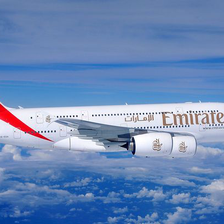

In [70]:
file = BytesIO(urllib.urlopen(SCOREURL).read())
img = Image.open(file).convert('RGB')
img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
img  # Show

In [74]:
imgio = BytesIO()
img.save(imgio, 'PNG')
imgio.seek(0)
dataimg = base64.b64encode(imgio.read())
jsonimg = json.dumps({'input':'[\"{0}\"]'.format(dataimg.decode('utf-8'))})

In [75]:
headers = {'content-type': 'application/json',
           'X-Marathon-App-Id': '/cntkservice'}

In [92]:
url = 'http://127.0.0.1:32770/score'

In [93]:
%time r = requests.post(url, data=jsonimg, headers=headers)

CPU times: user 2.67 ms, sys: 2.38 ms, total: 5.05 ms
Wall time: 242 ms


In [94]:
def classification_res(r):
    return str(r.json()['result'][0][0][0][0]).split(' ')[1:]

classification_res(r)

['airliner']

## Score Image using ACS (cluster)

In [ ]:
# Mat: this requires inputs ..
#!source ~/.amlenvrc;aml env cluster

In [97]:
!source ~/.amlenvrc; aml service create realtime -r cntk-py -f driver.py -m ResNet_18.model -d synset.txt -n cntkservice

Uploading dependencies.
 ResNet_18.model
 synset.txt
 /anaconda/envs/py35/lib/python3.5/site-packages/azuremlcli/azuremlutilities.py
Creating docker image....done.
Image available at : iliacontaineracr.azurecr.io/cntkservice
Deployment id: d601dc54-1169-4cf2-a34e-575858b9dbf8
Success.
Usage: aml service run realtime -n cntkservice [-d '{"input" : "!! YOUR DATA HERE !!"}']


In [98]:
url = 'http://iliacontaineracsagent.eastus.cloudapp.azure.com/score'

In [100]:
%time r = requests.post(url, data=jsonimg, headers=headers)

CPU times: user 3.55 ms, sys: 1.18 ms, total: 4.74 ms
Wall time: 307 ms


In [102]:
def classification_res(r):
    return str(r.json()['result'][0][0][0][0]).split(' ')[1:]

classification_res(r)

['airliner']

## Another Example

In [110]:
SCOREURL = 'http://img.burrard-lucas.com/zambia/full/hippo_charge.jpg'

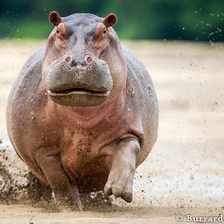

In [111]:
file = BytesIO(urllib.urlopen(SCOREURL).read())
img = Image.open(file).convert('RGB')
img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
img  # Show

In [112]:
imgio = BytesIO()
img.save(imgio, 'PNG')
imgio.seek(0)
dataimg = base64.b64encode(imgio.read())
jsonimg = json.dumps({'input':'[\"{0}\"]'.format(dataimg.decode('utf-8'))})

In [113]:
headers = {'content-type': 'application/json',
           'X-Marathon-App-Id': '/cntkservice'}

In [114]:
url = 'http://iliacontaineracsagent.eastus.cloudapp.azure.com/score'

In [115]:
%time r = requests.post(url, data=jsonimg, headers=headers)

CPU times: user 3.6 ms, sys: 78 µs, total: 3.68 ms
Wall time: 369 ms


In [120]:
def classification_res(r):
    return str(r.json()['result'][0][0][0][0]).split(' ')[1:]

classification_res(r)

['hippopotamus,', 'hippo,', 'river', 'horse,', 'Hippopotamus', 'amphibius']